# Model Tuning

In this part we'll find optimal model adjustments

In [1]:
#install and import libraries
!pip install catboost

     |████████████████████████████████| 76.3 MB 1.1 MB/s 


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.multioutput import RegressorChain
from sklearn.preprocessing import LabelEncoder
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import TimeSeriesSplit
from sklearn import linear_model
from statsmodels.tsa.seasonal import seasonal_decompose
import os
import glob
from catboost import CatBoostRegressor, Pool

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
#load the stations's data
shab = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Moscow_contest/shab.csv', decimal=',')
shab = shab.set_index('data_time')
shab.head()

,Unnamed: 0,CO,NO2,NO,PM10,-T-,| V |,_V_,Давление,Влажность,Осадки,0,50,100,150,200,250,300,350,400,450,500,550,600,OutsideTemperature,Quality
data_time,,,,,,,,,,,,,,,,,,,,,,,,,,
01/01/2020 00:00:00,0,0.21,0.015,0.001,0.01,2.0,0.0,0.0,732.6,91.0,0.0,1.80,2.59,2.70,2.36,1.80,0.91,0.04,-0.57,-0.89,-1.18,-1.41,-1.58,-1.74,1.79,0.0
01/01/2020 00:20:00,1,0.2,0.0126,0.001,0.009,2.1,0.0,0.0,732.7,91.0,0.0,1.81,2.71,2.82,2.38,1.69,0.77,-0.14,-0.76,-1.08,-1.35,-1.55,-1.66,-1.77,1.85,0.0
01/01/2020 00:40:00,2,0.19,0.0129,0.001,0.01,2.1,0.0,0.0,732.8,91.0,0.0,1.85,2.69,2.80,2.47,1.76,0.88,0.00,-0.61,-0.95,-1.23,-1.44,-1.56,-1.69,1.85,0.0
01/01/2020 01:00:00,3,0.19,0.0129,0.001,0.012,2.1,0.0,0.0,732.9,91.0,0.0,1.81,2.57,2.63,2.24,1.67,0.86,0.14,-0.33,-0.56,-0.78,-0.92,-0.99,-1.05,1.81,0.0
01/01/2020 01:20:00,4,0.2,0.0135,0.001,0.012,2.0,0.0,0.0,732.9,91.0,0.0,1.75,2.44,2.49,2.15,1.57,0.77,-0.01,-0.55,-0.82,-1.07,-1.26,-1.38,-1.50,1.71,0.0


In [5]:
#convert object data to numeric
def to_numeric(data):
  data = data.copy()
  s = (data.dtypes == 'object')
  object_cols = s[s].index
  for col in object_cols:
    data[col] = data[col].astype('float')
  return data

In [6]:
# run data preprocessing
def preprocessing(data):
  data = data.copy()
  garbage_cols = [col for col in data.columns if ('Unnamed' in col)]
  data = data.drop(garbage_cols, axis=1)
  data.index = pd.to_datetime(data.index)
  data = data.sort_index()
  data = data.resample('1H').sum()
  return data

In [7]:
# select target columns
def get_target(data):
  target_cols = set(data.columns).intersection(set(['CO', 'NO2', 'NO', 'PM10', 'PM2.5', 'PM25']))
  return list(target_cols)

In [8]:
# clean the dataset
data_clear = to_numeric(shab)
data_clear = preprocessing(data_clear)
data_clear.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8785 entries, 2020-01-01 00:00:00 to 2021-01-01 00:00:00
Freq: H
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CO                  8785 non-null   float64
 1   NO2                 8785 non-null   float64
 2   NO                  8785 non-null   float64
 3   PM10                8785 non-null   float64
 4   -T-                 8785 non-null   float64
 5   | V |               8785 non-null   float64
 6   _V_                 8785 non-null   float64
 7   Давление            8785 non-null   float64
 8   Влажность           8785 non-null   float64
 9   Осадки              8785 non-null   float64
 10  0                   8785 non-null   float64
 11  50                  8785 non-null   float64
 12  100                 8785 non-null   float64
 13  150                 8785 non-null   float64
 14  200                 8785 non-null   float64
 15  250        

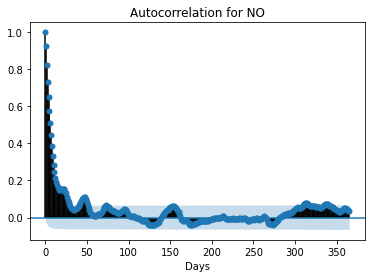

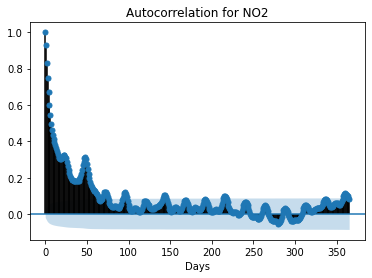

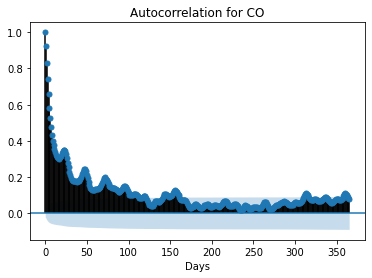

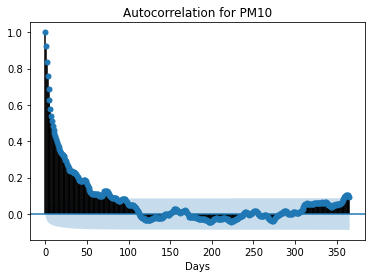

In [9]:
#targets autocorrelation function
for col in get_target(data_clear):
  plot_acf(x=data_clear[col], lags=365, title='Autocorrelation for {}'.format(col))
  plt.xlabel("Days")
  plt.show()

In [ ]:
#extract components of date, moving average, moving standard deviation for each indicators, sesonality and trend for one of them (CO)
def make_features(data, max_lag, moving_average_size):
  data_new = data.copy()
  data_new['year'] = data_new.index.year
  data_new['month'] = data_new.index.month
  data_new['day'] = data_new.index.day
  data_new['dayofweek'] = data_new.index.dayofweek

  for col in get_target(data):
    data_new['moving_average_{}'.format(col)] = data_new[col].shift().rolling(moving_average_size).mean()
    data_new['std_{}'.format(col)] = data_new[col].shift().rolling(moving_average_size).std()

    for lag in range(1, max_lag + 1):
        data_new['lag_{}'.format([col, lag])] = data_new[col].shift(lag)
  
  decomposed = seasonal_decompose(data_new['CO'])
  data_new['seasonality'] = decomposed.seasonal.shift()
  data_new['trend'] = decomposed.trend.shift()
  
  return data_new

In [ ]:
#find optimal moving_average_size
best_mape = 2
best_smape = 2

for moving_average_size in np.arange(10, 200, 10):
  data_clear = make_features(data_clear, 10, moving_average_size)
  
  data_clear = data_clear.dropna()

  target = data_clear[['CO', 'NO2', 'NO', 'PM10']]
  features = data_clear.drop(['CO','NO2', 'NO', 'PM10'], axis=1)

  model = linear_model.Lasso(alpha=0.2, normalize=True)

  def smape(A, F):
    return 1/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

  def mape(A, F):
    return (abs((A-F) / A)).median()

  # do CV
  tscv = TimeSeriesSplit(n_splits=3)
  data_clear_drop_index = data_clear.reset_index().drop('data_time', axis=1)
  features_drop = features.reset_index().drop('data_time', axis=1)
  target_drop = target.reset_index().drop('data_time', axis=1)
  scores_mape = []
  scores_smape = []

  for train_index, test_index in tscv.split(data_clear_drop_index):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = features_drop.loc[train_index], features_drop.loc[test_index]
    y_train, y_test = target_drop.loc[train_index], target_drop.loc[test_index]

    model = model.fit(X_train, y_train)
    predictions = pd.DataFrame(model.predict(X_test), columns = ['CO', 'NO2', 'NO', 'PM10'], index = y_test.index)
    

    score_mape = mape(y_test, predictions)
    score_smape = smape(y_test, predictions)
    scores_mape.append(score_mape)
    scores_smape.append(score_smape)

  final_score_mape = pd.DataFrame(scores_mape).mean(axis=0)
  final_score_smape = pd.DataFrame(scores_smape).mean(axis=0)

  if final_score_mape[1] < best_mape:
    best_mape = final_score_mape[1]
    best_ma = moving_average_size

  if final_score_smape[1] < best_smape:
    best_smape = final_score_smape[1]  

print('moving_average_size', best_ma)
print('MAPE', final_score_mape)
print()
print('SMAPE', final_score_smape)
print('------------------------------------------------------')


TRAIN: [   0    1    2 ... 2182 2183 2184] TEST: [2185 2186 2187 ... 4366 4367 4368]
TRAIN: [   0    1    2 ... 4366 4367 4368] TEST: [4369 4370 4371 ... 6550 6551 6552]
TRAIN: [   0    1    2 ... 6550 6551 6552] TEST: [6553 6554 6555 ... 8734 8735 8736]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 2175 2176 2177] TEST: [2178 2179 2180 ... 4351 4352 4353]
TRAIN: [   0    1    2 ... 4351 4352 4353] TEST: [4354 4355 4356 ... 6527 6528 6529]
TRAIN: [   0    1    2 ... 6527 6528 6529] TEST: [6530 6531 6532 ... 8703 8704 8705]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 2164 2165 2166] TEST: [2167 2168 2169 ... 4330 4331 4332]
TRAIN: [   0    1    2 ... 4330 4331 4332] TEST: [4333 4334 4335 ... 6496 6497 6498]
TRAIN: [   0    1    2 ... 6496 6497 6498] TEST: [6499 6500 6501 ... 8662 8663 8664]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 2152 2153 2154] TEST: [2155 2156 2157 ... 4305 4306 4307]
TRAIN: [   0    1    2 ... 4305 4306 4307] TEST: [4308 4309 4310 ... 6458 6459 6460]
TRAIN: [   0    1    2 ... 6458 6459 6460] TEST: [6461 6462 6463 ... 8611 8612 8613]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 2136 2137 2138] TEST: [2139 2140 2141 ... 4274 4275 4276]
TRAIN: [   0    1    2 ... 4274 4275 4276] TEST: [4277 4278 4279 ... 6412 6413 6414]
TRAIN: [   0    1    2 ... 6412 6413 6414] TEST: [6415 6416 6417 ... 8550 8551 8552]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 2119 2120 2121] TEST: [2122 2123 2124 ... 4239 4240 4241]
TRAIN: [   0    1    2 ... 4239 4240 4241] TEST: [4242 4243 4244 ... 6359 6360 6361]
TRAIN: [   0    1    2 ... 6359 6360 6361] TEST: [6362 6363 6364 ... 8479 8480 8481]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 2098 2099 2100] TEST: [2101 2102 2103 ... 4198 4199 4200]
TRAIN: [   0    1    2 ... 4198 4199 4200] TEST: [4201 4202 4203 ... 6298 6299 6300]
TRAIN: [   0    1    2 ... 6298 6299 6300] TEST: [6301 6302 6303 ... 8398 8399 8400]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 2076 2077 2078] TEST: [2079 2080 2081 ... 4153 4154 4155]
TRAIN: [   0    1    2 ... 4153 4154 4155] TEST: [4156 4157 4158 ... 6230 6231 6232]
TRAIN: [   0    1    2 ... 6230 6231 6232] TEST: [6233 6234 6235 ... 8307 8308 8309]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 2050 2051 2052] TEST: [2053 2054 2055 ... 4102 4103 4104]
TRAIN: [   0    1    2 ... 4102 4103 4104] TEST: [4105 4106 4107 ... 6154 6155 6156]
TRAIN: [   0    1    2 ... 6154 6155 6156] TEST: [6157 6158 6159 ... 8206 8207 8208]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 2023 2024 2025] TEST: [2026 2027 2028 ... 4047 4048 4049]
TRAIN: [   0    1    2 ... 4047 4048 4049] TEST: [4050 4051 4052 ... 6071 6072 6073]
TRAIN: [   0    1    2 ... 6071 6072 6073] TEST: [6074 6075 6076 ... 8095 8096 8097]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 1992 1993 1994] TEST: [1995 1996 1997 ... 3986 3987 3988]
TRAIN: [   0    1    2 ... 3986 3987 3988] TEST: [3989 3990 3991 ... 5980 5981 5982]
TRAIN: [   0    1    2 ... 5980 5981 5982] TEST: [5983 5984 5985 ... 7974 7975 7976]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 1960 1961 1962] TEST: [1963 1964 1965 ... 3921 3922 3923]
TRAIN: [   0    1    2 ... 3921 3922 3923] TEST: [3924 3925 3926 ... 5882 5883 5884]
TRAIN: [   0    1    2 ... 5882 5883 5884] TEST: [5885 5886 5887 ... 7843 7844 7845]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 1924 1925 1926] TEST: [1927 1928 1929 ... 3850 3851 3852]
TRAIN: [   0    1    2 ... 3850 3851 3852] TEST: [3853 3854 3855 ... 5776 5777 5778]
TRAIN: [   0    1    2 ... 5776 5777 5778] TEST: [5779 5780 5781 ... 7702 7703 7704]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 1887 1888 1889] TEST: [1890 1891 1892 ... 3775 3776 3777]
TRAIN: [   0    1    2 ... 3775 3776 3777] TEST: [3778 3779 3780 ... 5663 5664 5665]
TRAIN: [   0    1    2 ... 5663 5664 5665] TEST: [5666 5667 5668 ... 7551 7552 7553]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 1846 1847 1848] TEST: [1849 1850 1851 ... 3694 3695 3696]
TRAIN: [   0    1    2 ... 3694 3695 3696] TEST: [3697 3698 3699 ... 5542 5543 5544]
TRAIN: [   0    1    2 ... 5542 5543 5544] TEST: [5545 5546 5547 ... 7390 7391 7392]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 1804 1805 1806] TEST: [1807 1808 1809 ... 3609 3610 3611]
TRAIN: [   0    1    2 ... 3609 3610 3611] TEST: [3612 3613 3614 ... 5414 5415 5416]
TRAIN: [   0    1    2 ... 5414 5415 5416] TEST: [5417 5418 5419 ... 7219 7220 7221]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 1758 1759 1760] TEST: [1761 1762 1763 ... 3518 3519 3520]
TRAIN: [   0    1    2 ... 3518 3519 3520] TEST: [3521 3522 3523 ... 5278 5279 5280]
TRAIN: [   0    1    2 ... 5278 5279 5280] TEST: [5281 5282 5283 ... 7038 7039 7040]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 1711 1712 1713] TEST: [1714 1715 1716 ... 3423 3424 3425]
TRAIN: [   0    1    2 ... 3423 3424 3425] TEST: [3426 3427 3428 ... 5135 5136 5137]
TRAIN: [   0    1    2 ... 5135 5136 5137] TEST: [5138 5139 5140 ... 6847 6848 6849]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 1660 1661 1662] TEST: [1663 1664 1665 ... 3322 3323 3324]
TRAIN: [   0    1    2 ... 3322 3323 3324] TEST: [3325 3326 3327 ... 4984 4985 4986]
TRAIN: [   0    1    2 ... 4984 4985 4986] TEST: [4987 4988 4989 ... 6646 6647 6648]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

moving_average_size 180
MAPE CO      0.372960
NO2     0.563542
NO      1.867616
PM10    0.582109
dtype: float64

SMAPE CO      0.516176
NO2     0.651327
NO      1.181406
PM10    0.668502
dtype: float64
------------------------------------------------------


In [ ]:
# find optimal max_lag

best_mape = 2
best_smape = 2

for max_lag in np.arange(0, 360, 10):
  data_clear = make_features(data_clear, max_lag, 80)
  
  data_clear = data_clear.dropna()

  target = data_clear[['CO', 'NO2', 'NO', 'PM10']]
  features = data_clear.drop(['CO','NO2', 'NO', 'PM10'], axis=1)

  model = linear_model.Lasso(alpha=0.2, normalize=True)

  def smape(A, F):
    return 1/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

  def mape(A, F):
    return (abs((A-F) / A)).median()

  # do CV
  tscv = TimeSeriesSplit(n_splits=3)
  data_clear_drop_index = data_clear.reset_index().drop('data_time', axis=1)
  features_drop = features.reset_index().drop('data_time', axis=1)
  target_drop = target.reset_index().drop('data_time', axis=1)
  scores_mape = []
  scores_smape = []


  for train_index, test_index in tscv.split(data_clear_drop_index):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = features_drop.loc[train_index], features_drop.loc[test_index]
    y_train, y_test = target_drop.loc[train_index], target_drop.loc[test_index]

    model = model.fit(X_train, y_train)
    predictions = pd.DataFrame(model.predict(X_test), columns = ['CO', 'NO2', 'NO', 'PM10'], index = y_test.index)
    

    score_mape = mape(y_test, predictions)
    score_smape = smape(y_test, predictions)
    scores_mape.append(score_mape)
    scores_smape.append(score_smape)

  final_score_mape = pd.DataFrame(scores_mape).mean(axis=0)
  final_score_smape = pd.DataFrame(scores_smape).mean(axis=0)

  if final_score_mape[1] < best_mape:
    best_mape = final_score_mape[1]
    best_max_lag = max_lag

  if final_score_smape[1] < best_smape:
    best_smape = final_score_smape[1]  

print('max_lag', best_max_lag)
print('MAPE', final_score_mape)
print()
print('SMAPE', final_score_smape)
print('------------------------------------------------------')


TRAIN: [   0    1    2 ... 2172 2173 2174] TEST: [2175 2176 2177 ... 4345 4346 4347]
TRAIN: [   0    1    2 ... 4345 4346 4347] TEST: [4348 4349 4350 ... 6518 6519 6520]
TRAIN: [   0    1    2 ... 6518 6519 6520] TEST: [6521 6522 6523 ... 8691 8692 8693]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 2150 2151 2152] TEST: [2153 2154 2155 ... 4300 4301 4302]
TRAIN: [   0    1    2 ... 4300 4301 4302] TEST: [4303 4304 4305 ... 6450 6451 6452]
TRAIN: [   0    1    2 ... 6450 6451 6452] TEST: [6453 6454 6455 ... 8600 8601 8602]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 2125 2126 2127] TEST: [2128 2129 2130 ... 4253 4254 4255]
TRAIN: [   0    1    2 ... 4253 4254 4255] TEST: [4256 4257 4258 ... 6381 6382 6383]
TRAIN: [   0    1    2 ... 6381 6382 6383] TEST: [6384 6385 6386 ... 8509 8510 8511]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 2103 2104 2105] TEST: [2106 2107 2108 ... 4208 4209 4210]
TRAIN: [   0    1    2 ... 4208 4209 4210] TEST: [4211 4212 4213 ... 6313 6314 6315]
TRAIN: [   0    1    2 ... 6313 6314 6315] TEST: [6316 6317 6318 ... 8418 8419 8420]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 2081 2082 2083] TEST: [2084 2085 2086 ... 4163 4164 4165]
TRAIN: [   0    1    2 ... 4163 4164 4165] TEST: [4166 4167 4168 ... 6245 6246 6247]
TRAIN: [   0    1    2 ... 6245 6246 6247] TEST: [6248 6249 6250 ... 8327 8328 8329]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 2059 2060 2061] TEST: [2062 2063 2064 ... 4118 4119 4120]
TRAIN: [   0    1    2 ... 4118 4119 4120] TEST: [4121 4122 4123 ... 6177 6178 6179]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 6177 6178 6179] TEST: [6180 6181 6182 ... 8236 8237 8238]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,


TRAIN: [   0    1    2 ... 2034 2035 2036] TEST: [2037 2038 2039 ... 4071 4072 4073]
TRAIN: [   0    1    2 ... 4071 4072 4073] TEST: [4074 4075 4076 ... 6108 6109 6110]
TRAIN: [   0    1    2 ... 6108 6109 6110] TEST: [6111 6112 6113 ... 8145 8146 8147]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 2012 2013 2014] TEST: [2015 2016 2017 ... 4026 4027 4028]
TRAIN: [   0    1    2 ... 4026 4027 4028] TEST: [4029 4030 4031 ... 6040 6041 6042]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 6040 6041 6042] TEST: [6043 6044 6045 ... 8054 8055 8056]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,


TRAIN: [   0    1    2 ... 1990 1991 1992] TEST: [1993 1994 1995 ... 3981 3982 3983]
TRAIN: [   0    1    2 ... 3981 3982 3983] TEST: [3984 3985 3986 ... 5972 5973 5974]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 5972 5973 5974] TEST: [5975 5976 5977 ... 7963 7964 7965]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,


TRAIN: [   0    1    2 ... 1964 1965 1966] TEST: [1967 1968 1969 ... 3930 3931 3932]
TRAIN: [   0    1    2 ... 3930 3931 3932] TEST: [3933 3934 3935 ... 5896 5897 5898]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 5896 5897 5898] TEST: [5899 5900 5901 ... 7862 7863 7864]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,


TRAIN: [   0    1    2 ... 1937 1938 1939] TEST: [1940 1941 1942 ... 3875 3876 3877]
TRAIN: [   0    1    2 ... 3875 3876 3877] TEST: [3878 3879 3880 ... 5813 5814 5815]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 5813 5814 5815] TEST: [5816 5817 5818 ... 7751 7752 7753]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,


TRAIN: [   0    1    2 ... 1906 1907 1908] TEST: [1909 1910 1911 ... 3814 3815 3816]
TRAIN: [   0    1    2 ... 3814 3815 3816] TEST: [3817 3818 3819 ... 5722 5723 5724]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 5722 5723 5724] TEST: [5725 5726 5727 ... 7630 7631 7632]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,


TRAIN: [   0    1    2 ... 1874 1875 1876] TEST: [1877 1878 1879 ... 3749 3750 3751]
TRAIN: [   0    1    2 ... 3749 3750 3751] TEST: [3752 3753 3754 ... 5624 5625 5626]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 5624 5625 5626] TEST: [5627 5628 5629 ... 7499 7500 7501]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,


TRAIN: [   0    1    2 ... 1838 1839 1840] TEST: [1841 1842 1843 ... 3678 3679 3680]
TRAIN: [   0    1    2 ... 3678 3679 3680] TEST: [3681 3682 3683 ... 5518 5519 5520]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 5518 5519 5520] TEST: [5521 5522 5523 ... 7358 7359 7360]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,


TRAIN: [   0    1    2 ... 1801 1802 1803] TEST: [1804 1805 1806 ... 3603 3604 3605]
TRAIN: [   0    1    2 ... 3603 3604 3605] TEST: [3606 3607 3608 ... 5405 5406 5407]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 5405 5406 5407] TEST: [5408 5409 5410 ... 7207 7208 7209]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,


TRAIN: [   0    1    2 ... 1760 1761 1762] TEST: [1763 1764 1765 ... 3522 3523 3524]
TRAIN: [   0    1    2 ... 3522 3523 3524] TEST: [3525 3526 3527 ... 5284 5285 5286]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 5284 5285 5286] TEST: [5287 5288 5289 ... 7046 7047 7048]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,


TRAIN: [   0    1    2 ... 1718 1719 1720] TEST: [1721 1722 1723 ... 3437 3438 3439]
TRAIN: [   0    1    2 ... 3437 3438 3439] TEST: [3440 3441 3442 ... 5156 5157 5158]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 5156 5157 5158] TEST: [5159 5160 5161 ... 6875 6876 6877]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,


TRAIN: [   0    1    2 ... 1672 1673 1674] TEST: [1675 1676 1677 ... 3346 3347 3348]
TRAIN: [   0    1    2 ... 3346 3347 3348] TEST: [3349 3350 3351 ... 5020 5021 5022]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 5020 5021 5022] TEST: [5023 5024 5025 ... 6694 6695 6696]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,


TRAIN: [   0    1    2 ... 1625 1626 1627] TEST: [1628 1629 1630 ... 3251 3252 3253]
TRAIN: [   0    1    2 ... 3251 3252 3253] TEST: [3254 3255 3256 ... 4877 4878 4879]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 4877 4878 4879] TEST: [4880 4881 4882 ... 6503 6504 6505]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,


TRAIN: [   0    1    2 ... 1574 1575 1576] TEST: [1577 1578 1579 ... 3150 3151 3152]
TRAIN: [   0    1    2 ... 3150 3151 3152] TEST: [3153 3154 3155 ... 4726 4727 4728]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 4726 4727 4728] TEST: [4729 4730 4731 ... 6302 6303 6304]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,


TRAIN: [   0    1    2 ... 1522 1523 1524] TEST: [1525 1526 1527 ... 3045 3046 3047]
TRAIN: [   0    1    2 ... 3045 3046 3047] TEST: [3048 3049 3050 ... 4568 4569 4570]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 4568 4569 4570] TEST: [4571 4572 4573 ... 6091 6092 6093]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,


TRAIN: [   0    1    2 ... 1466 1467 1468] TEST: [1469 1470 1471 ... 2934 2935 2936]
TRAIN: [   0    1    2 ... 2934 2935 2936] TEST: [2937 2938 2939 ... 4402 4403 4404]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 4402 4403 4404] TEST: [4405 4406 4407 ... 5870 5871 5872]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,


TRAIN: [   0    1    2 ... 1409 1410 1411] TEST: [1412 1413 1414 ... 2819 2820 2821]
TRAIN: [   0    1    2 ... 2819 2820 2821] TEST: [2822 2823 2824 ... 4229 4230 4231]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 4229 4230 4231] TEST: [4232 4233 4234 ... 5639 5640 5641]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,


TRAIN: [   0    1    2 ... 1348 1349 1350] TEST: [1351 1352 1353 ... 2698 2699 2700]
TRAIN: [   0    1    2 ... 2698 2699 2700] TEST: [2701 2702 2703 ... 4048 4049 4050]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 4048 4049 4050] TEST: [4051 4052 4053 ... 5398 5399 5400]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,


TRAIN: [   0    1    2 ... 1286 1287 1288] TEST: [1289 1290 1291 ... 2573 2574 2575]
TRAIN: [   0    1    2 ... 2573 2574 2575] TEST: [2576 2577 2578 ... 3860 3861 3862]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 3860 3861 3862] TEST: [3863 3864 3865 ... 5147 5148 5149]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,


TRAIN: [   0    1    2 ... 1220 1221 1222] TEST: [1223 1224 1225 ... 2442 2443 2444]
TRAIN: [   0    1    2 ... 2442 2443 2444] TEST: [2445 2446 2447 ... 3664 3665 3666]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 3664 3665 3666] TEST: [3667 3668 3669 ... 4886 4887 4888]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,


TRAIN: [   0    1    2 ... 1153 1154 1155] TEST: [1156 1157 1158 ... 2307 2308 2309]
TRAIN: [   0    1    2 ... 2307 2308 2309] TEST: [2310 2311 2312 ... 3461 3462 3463]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 3461 3462 3463] TEST: [3464 3465 3466 ... 4615 4616 4617]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,


TRAIN: [   0    1    2 ... 1082 1083 1084] TEST: [1085 1086 1087 ... 2166 2167 2168]
TRAIN: [   0    1    2 ... 2166 2167 2168] TEST: [2169 2170 2171 ... 3250 3251 3252]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 3250 3251 3252] TEST: [3253 3254 3255 ... 4334 4335 4336]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,


TRAIN: [   0    1    2 ... 1010 1011 1012] TEST: [1013 1014 1015 ... 2021 2022 2023]
TRAIN: [   0    1    2 ... 2021 2022 2023] TEST: [2024 2025 2026 ... 3032 3033 3034]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 3032 3033 3034] TEST: [3035 3036 3037 ... 4043 4044 4045]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,


TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 2806 2807 2808] TEST: [2809 2810 2811 2812 2813 2814 2815 2816 2817 2818 2819 2820 2821 2822
 2823 2824 2825 2826 2827 2828 2829 2830 2831 2832 2833 2834 2835 2836
 2837 2838 2839 2840 2841 2842 2843 2844 2845 2846 2847 2848 2849 2850
 2851 2852 2853 2854 2855 2856 2857 2858 2859 2860 2861 2862 2863 2864
 2865 2866 2867 2868 2869 2870 2871 2872 2873 2874 2875 2876 2877 2878
 2879 2880 2881 2882 2883 2884 2885 2886 2887 2888 2889 2890 2891 2892
 2893 2894 2895 2896 2897 2898 2899 2900 2901 2902 2903 2904 2905 2906
 2907 2908 2909 2910 2911 2912 2913 2914 2915 2916 2917 2918 2919 2920
 2921 2922 2923 2924 2925 2926 2927 2928 2929 2930 2931 2932 2933 2934
 2935 2936 2937 2938 2939 2940 2941 2942 2943 2944 2945 2946 2947 2948
 2949 2950 2951 2952 2953 2954 2955 2956 2957 2958 2959 2960 2961 2962
 2963 2964 2965 2966 2967 2968 2969 2970 2971 2972 2973 2974 2975 2976
 2977 2978 2979 2980 2981 2982 2983 2984 2985 2986 2987 2988 2989 2990
 2991 2992 2993 2994 2995 29

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,


TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 2573 2574 2575] TEST: [2576 2577 2578 2579 2580 2581 2582 2583 2584 2585 2586 2587 2588 2589
 2590 2591 2592 2593 2594 2595 2596 2597 2598 2599 2600 2601 2602 2603
 2604 2605 2606 2607 2608 2609 2610 2611 2612 2613 2614 2615 2616 2617
 2618 2619 2620 2621 2622 2623 2624 2625 2626 2627 2628 2629 2630 2631
 2632 2633 2634 2635 2636 2637 2638 2639 2640 2641 2642 2643 2644 2645
 2646 2647 2648 2649 2650 2651 2652 2653 2654 2655 2656 2657 2658 2659
 2660 2661 2662 2663 2664 2665 2666 2667 2668 2669 2670 2671 2672 2673
 2674 2675 2676 2677 2678 2679 2680 2681 2682 2683 2684 2685 2686 2687
 2688 2689 2690 2691 2692 2693 2694 2695 2696 2697 2698 2699 2700 2701
 2702 2703 2704 2705 2706 2707 2708 2709 2710 2711 2712 2713 2714 2715
 2716 2717 2718 2719 2720 2721 2722 2723 2724 2725 2726 2727 2728 2729
 2730 2731 2732 2733 2734 2735 2736 2737 2738 2739 2740 2741 2742 2743
 2744 2745 2746 2747 2748 2749 2750 2751 2752 2753 2754 2755 2756 2757
 2758 2759 2760 2761 2762 27

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,


TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 2332 2333 2334] TEST: [2335 2336 2337 2338 2339 2340 2341 2342 2343 2344 2345 2346 2347 2348
 2349 2350 2351 2352 2353 2354 2355 2356 2357 2358 2359 2360 2361 2362
 2363 2364 2365 2366 2367 2368 2369 2370 2371 2372 2373 2374 2375 2376
 2377 2378 2379 2380 2381 2382 2383 2384 2385 2386 2387 2388 2389 2390
 2391 2392 2393 2394 2395 2396 2397 2398 2399 2400 2401 2402 2403 2404
 2405 2406 2407 2408 2409 2410 2411 2412 2413 2414 2415 2416 2417 2418
 2419 2420 2421 2422 2423 2424 2425 2426 2427 2428 2429 2430 2431 2432
 2433 2434 2435 2436 2437 2438 2439 2440 2441 2442 2443 2444 2445 2446
 2447 2448 2449 2450 2451 2452 2453 2454 2455 2456 2457 2458 2459 2460
 2461 2462 2463 2464 2465 2466 2467 2468 2469 2470 2471 2472 2473 2474
 2475 2476 2477 2478 2479 2480 2481 2482 2483 2484 2485 2486 2487 2488
 2489 2490 2491 2492 2493 2494 2495 2496 2497 2498 2499 2500 2501 2502
 2503 2504 2505 2506 2507 2508 2509 2510 2511 2512 2513 2514 2515 2516
 2517 2518 2519 2520 2521 25

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,


TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 2084 2085 2086] TEST: [2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100
 2101 2102 2103 2104 2105 2106 2107 2108 2109 2110 2111 2112 2113 2114
 2115 2116 2117 2118 2119 2120 2121 2122 2123 2124 2125 2126 2127 2128
 2129 2130 2131 2132 2133 2134 2135 2136 2137 2138 2139 2140 2141 2142
 2143 2144 2145 2146 2147 2148 2149 2150 2151 2152 2153 2154 2155 2156
 2157 2158 2159 2160 2161 2162 2163 2164 2165 2166 2167 2168 2169 2170
 2171 2172 2173 2174 2175 2176 2177 2178 2179 2180 2181 2182 2183 2184
 2185 2186 2187 2188 2189 2190 2191 2192 2193 2194 2195 2196 2197 2198
 2199 2200 2201 2202 2203 2204 2205 2206 2207 2208 2209 2210 2211 2212
 2213 2214 2215 2216 2217 2218 2219 2220 2221 2222 2223 2224 2225 2226
 2227 2228 2229 2230 2231 2232 2233 2234 2235 2236 2237 2238 2239 2240
 2241 2242 2243 2244 2245 2246 2247 2248 2249 2250 2251 2252 2253 2254
 2255 2256 2257 2258 2259 2260 2261 2262 2263 2264 2265 2266 2267 2268
 2269 2270 2271 2272 2273 22

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,


TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 1828 1829 1830] TEST: [1831 1832 1833 1834 1835 1836 1837 1838 1839 1840 1841 1842 1843 1844
 1845 1846 1847 1848 1849 1850 1851 1852 1853 1854 1855 1856 1857 1858
 1859 1860 1861 1862 1863 1864 1865 1866 1867 1868 1869 1870 1871 1872
 1873 1874 1875 1876 1877 1878 1879 1880 1881 1882 1883 1884 1885 1886
 1887 1888 1889 1890 1891 1892 1893 1894 1895 1896 1897 1898 1899 1900
 1901 1902 1903 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914
 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928
 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942
 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956
 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970
 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984
 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998
 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012
 2013 2014 2015 2016 2017 20

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,


TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 1565 1566 1567] TEST: [1568 1569 1570 1571 1572 1573 1574 1575 1576 1577 1578 1579 1580 1581
 1582 1583 1584 1585 1586 1587 1588 1589 1590 1591 1592 1593 1594 1595
 1596 1597 1598 1599 1600 1601 1602 1603 1604 1605 1606 1607 1608 1609
 1610 1611 1612 1613 1614 1615 1616 1617 1618 1619 1620 1621 1622 1623
 1624 1625 1626 1627 1628 1629 1630 1631 1632 1633 1634 1635 1636 1637
 1638 1639 1640 1641 1642 1643 1644 1645 1646 1647 1648 1649 1650 1651
 1652 1653 1654 1655 1656 1657 1658 1659 1660 1661 1662 1663 1664 1665
 1666 1667 1668 1669 1670 1671 1672 1673 1674 1675 1676 1677 1678 1679
 1680 1681 1682 1683 1684 1685 1686 1687 1688 1689 1690 1691 1692 1693
 1694 1695 1696 1697 1698 1699 1700 1701 1702 1703 1704 1705 1706 1707
 1708 1709 1710 1711 1712 1713 1714 1715 1716 1717 1718 1719 1720 1721
 1722 1723 1724 1725 1726 1727 1728 1729 1730 1731 1732 1733 1734 1735
 1736 1737 1738 1739 1740 1741 1742 1743 1744 1745 1746 1747 1748 1749
 1750 1751 1752 1753 1754 17

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,


TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skle

TRAIN: [   0    1    2 ... 1294 1295 1296] TEST: [1297 1298 1299 1300 1301 1302 1303 1304 1305 1306 1307 1308 1309 1310
 1311 1312 1313 1314 1315 1316 1317 1318 1319 1320 1321 1322 1323 1324
 1325 1326 1327 1328 1329 1330 1331 1332 1333 1334 1335 1336 1337 1338
 1339 1340 1341 1342 1343 1344 1345 1346 1347 1348 1349 1350 1351 1352
 1353 1354 1355 1356 1357 1358 1359 1360 1361 1362 1363 1364 1365 1366
 1367 1368 1369 1370 1371 1372 1373 1374 1375 1376 1377 1378 1379 1380
 1381 1382 1383 1384 1385 1386 1387 1388 1389 1390 1391 1392 1393 1394
 1395 1396 1397 1398 1399 1400 1401 1402 1403 1404 1405 1406 1407 1408
 1409 1410 1411 1412 1413 1414 1415 1416 1417 1418 1419 1420 1421 1422
 1423 1424 1425 1426 1427 1428 1429 1430 1431 1432 1433 1434 1435 1436
 1437 1438 1439 1440 1441 1442 1443 1444 1445 1446 1447 1448 1449 1450
 1451 1452 1453 1454 1455 1456 1457 1458 1459 1460 1461 1462 1463 1464
 1465 1466 1467 1468 1469 1470 1471 1472 1473 1474 1475 1476 1477 1478
 1479 1480 1481 1482 1483 14

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,


In [ ]:
model = MultiOutputRegressor(CatBoostRegressor(iterations=150, 
                          depth=3, 
                          learning_rate=0.15, 
                          loss_function='MAPE'))

In [ ]:
# find optimal hyperparameters
grid_params = [{'estimator__iterations': [50], 
                'estimator__depth': np.arange(3, 11, 2), 
                'estimator__learning_rate': [0.3, 0.15, 0.11]}] 

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)
gsearch = GridSearchCV(estimator=model,
                       cv=tscv,
                       param_grid=grid_params,
                       scoring='neg_mean_absolute_percentage_error') 

gsearch.fit(features, target)
print(gsearch.best_params_)

Streaming output truncated to the last 5000 lines.
1:	learn: 0.2009326	total: 86.1ms	remaining: 2.07s
2:	learn: 0.1852204	total: 130ms	remaining: 2.04s
3:	learn: 0.1722051	total: 164ms	remaining: 1.89s
4:	learn: 0.1589395	total: 199ms	remaining: 1.79s
5:	learn: 0.1470537	total: 235ms	remaining: 1.73s
6:	learn: 0.1395181	total: 271ms	remaining: 1.66s
7:	learn: 0.1313402	total: 311ms	remaining: 1.63s
8:	learn: 0.1254023	total: 354ms	remaining: 1.61s
9:	learn: 0.1202007	total: 393ms	remaining: 1.57s
10:	learn: 0.1154662	total: 429ms	remaining: 1.52s
11:	learn: 0.1109605	total: 466ms	remaining: 1.47s
12:	learn: 0.1083424	total: 500ms	remaining: 1.42s
13:	learn: 0.1054877	total: 535ms	remaining: 1.37s
14:	learn: 0.1021734	total: 583ms	remaining: 1.36s
15:	learn: 0.1002140	total: 620ms	remaining: 1.32s
16:	learn: 0.0980867	total: 659ms	remaining: 1.28s
17:	learn: 0.0951828	total: 695ms	remaining: 1.24s
18:	learn: 0.0931481	total: 730ms	remaining: 1.19s
19:	learn: 0.0918982	total: 768ms	remai

#Conclusion:

We figured out that the best parameters are following: moving_average_size 180, max_lag 350, max_depth 3, learning_rate 0.3. It's time to apply them in model building!